In [1]:
data_location = 'sqlite:///../../../data/data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [5]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)

In [6]:
# Data Formatting

# Lets prepare the data in the same way as the class

In [7]:
tokens = ohlc.token.unique()

In [8]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [9]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [11]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [12]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

In [13]:
X.head()

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2021-11-01 01:00:00,0.0,0.004357,0.0,0.006874,0.0,0.0000,0.0,0.027359,0.0,0.003203,...,0.0,-0.006346,0.0,0.008193,0.0,0.000725,0.0,0.008043,0.0,-0.002281
2021-11-01 02:00:00,0.0,-0.004508,0.0,-0.005322,0.0,-0.0002,0.0,-0.009879,0.0,-0.008667,...,0.0,-0.006231,0.0,-0.025419,0.0,-0.031791,0.0,-0.009171,0.0,-0.006020
2021-11-01 03:00:00,0.0,-0.012132,0.0,-0.013126,0.0,0.0001,0.0,-0.021692,0.0,-0.007618,...,0.0,-0.005329,0.0,-0.013943,0.0,-0.010431,0.0,-0.013301,0.0,-0.022273
2021-11-01 04:00:00,0.0,-0.010186,0.0,-0.010679,0.0,0.0000,0.0,-0.003039,0.0,-0.006903,...,0.0,-0.008667,0.0,-0.020046,0.0,0.004514,0.0,-0.016452,0.0,-0.024002


In [14]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22],
    'model__alpha': [0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [15]:
best_model = search.best_estimator_

In [16]:
evaluate_model(best_model, X, y)

-0.008575141851714433

In [17]:
# lets check the data
pd.options.display.max_columns = None
display(X.describe())

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,vol_DOT,ret_DOT,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
count,1056.000000,1055.000000,1056.000000,1055.000000,1056.000000,1.055000e+03,1056.000000,1055.000000,1056.000000,1055.000000,1056.000000,1055.000000,1056.000000,1055.000000,1056.000000,1055.000000,1056.000000,1055.000000,1056.000000,1055.000000,1056.000000,1055.000000
mean,0.122921,-0.000203,0.141079,-0.000073,0.007916,-2.644804e-07,0.207151,-0.000158,0.173014,-0.000363,0.207290,-0.000393,0.281194,0.000412,0.232459,-0.000419,0.298210,-0.000081,0.171459,-0.000540,0.192738,-0.000529
std,0.078234,0.006964,0.066514,0.008017,0.014568,1.986613e-04,0.090055,0.012015,0.092401,0.010123,0.105467,0.012322,0.110449,0.016733,0.134823,0.013517,0.139023,0.018283,0.096975,0.010022,0.098014,0.011391
min,0.000000,-0.049853,0.000000,-0.055916,0.000000,-1.893185e-03,0.000000,-0.053429,0.000000,-0.070535,0.000000,-0.061665,0.000000,-0.070042,0.000000,-0.069152,0.000000,-0.074284,0.000000,-0.068892,0.000000,-0.064433
25%,0.086592,-0.003914,0.102135,-0.004263,0.002370,-9.991008e-05,0.149508,-0.007447,0.117355,-0.005572,0.141890,-0.006506,0.215522,-0.009057,0.156846,-0.007044,0.211446,-0.010757,0.117232,-0.005673,0.134810,-0.006583
50%,0.105097,-0.000298,0.125898,-0.000064,0.003276,0.000000e+00,0.185238,-0.000503,0.157321,-0.000437,0.181394,-0.000403,0.260199,0.000000,0.206946,-0.000175,0.276759,-0.001184,0.152319,-0.000197,0.170088,0.000054
75%,0.138638,0.003365,0.165155,0.004344,0.004929,9.992006e-05,0.245490,0.006752,0.207250,0.004921,0.243753,0.006070,0.338723,0.010059,0.253502,0.006629,0.364968,0.010175,0.204675,0.005302,0.224627,0.005824
max,0.795166,0.034570,0.578180,0.030893,0.113821,4.194966e-03,0.774810,0.048298,0.749493,0.051771,0.908681,0.060994,0.952177,0.066178,1.009008,0.062979,1.137591,0.088334,0.925958,0.043170,0.779508,0.049172


Notice that the max values are quite far from the 75% quantile, we may need a more robust scaler

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', RobustScaler(quantile_range=(0.05,0.95))),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'scale__quantile_range': [(0.01,0.99), (0.05,0.95), (0.25,0.75)],
    'pca__n_components': [1, 5, 10, 20, 22],
    'model__alpha': [0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale',
                                        RobustScaler(quantile_range=(0.05,
                                                                     0.95))),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22],
                         'scale__quantile_range': [(0.01, 0.99), (0.05, 0.95),
                                                   (0.25, 0.75)]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [19]:
search.best_params_

{'model__alpha': 1.0,
 'pca__n_components': 20,
 'scale__quantile_range': (0.25, 0.75)}

In [20]:
best_model = search.best_estimator_

In [21]:
evaluate_model(best_model, X, y)

-0.00850270097140695

We have a better model! Let's try another kind of regressions to see if we get even better results

In [22]:
# Attempt with another model

from sklearn.svm import SVR

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', RobustScaler(quantile_range=(0.05,0.95))),
    ('pca', PCA()),
    ('model', SVR(kernel='poly'))
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'scale__quantile_range': [(0.01,0.99), (0.05,0.95), (0.25,0.75)],
    'pca__n_components': [10, 20, 22],
    'model__C': [0.5, 1.0,  5.0],
    'model__epsilon': [0.05, 0.1, 0.5]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale',
                                        RobustScaler(quantile_range=(0.05,
                                                                     0.95))),
                                       ('pca', PCA()),
                                       ('model', SVR(kernel='poly'))]),
             n_jobs=-1,
             param_grid={'model__C': [0.5, 1.0, 5.0],
                         'model__epsilon': [0.05, 0.1, 0.5],
                         'pca__n_components': [10, 20, 22],
                         'scale__quantile_range': [(0.01, 0.99), (0.05, 0.95),
                                                   (0.25, 0.75)]},
             scoring=make_scorer(mean_squ

In [23]:
search.best_params_

{'model__C': 1.0,
 'model__epsilon': 0.05,
 'pca__n_components': 10,
 'scale__quantile_range': (0.25, 0.75)}

In [24]:
best_model = search.best_estimator_

In [25]:
evaluate_model(best_model, X, y)

-0.008473578478184272

This improved our model so we keep it as the best. Now check the learning curves:

<module 'matplotlib.pyplot' from 'C:\\Users\\Tonijua\\anaconda3\\envs\\mfe-preprogram\\lib\\site-packages\\matplotlib\\pyplot.py'>

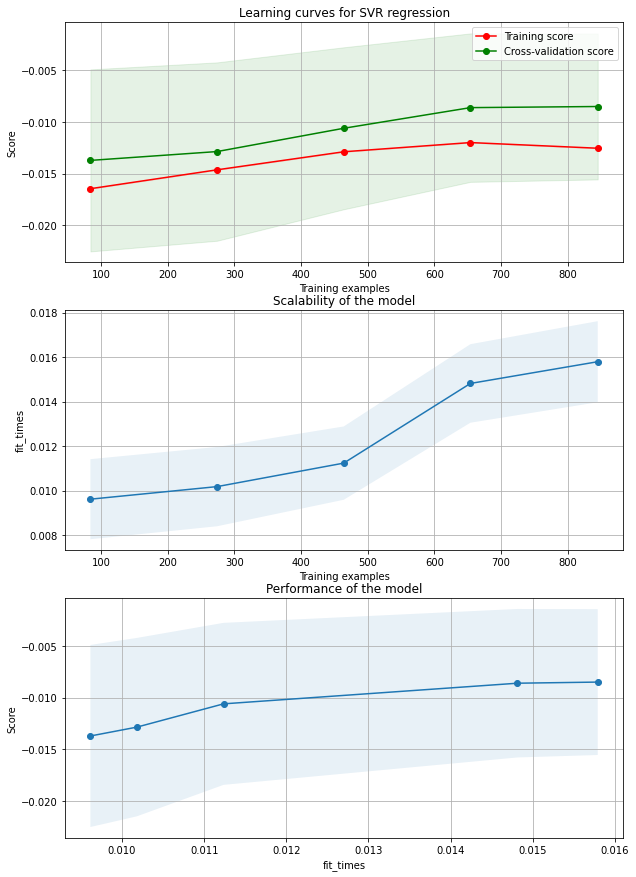

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for SVR regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


In [27]:
# Finally save the model
pickle.dump(best_model, open('best_model_juan_mora.pkl', 'wb'))